In [1]:
import pandas as pd
import numpy as np
import glob as glob
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, DrawingArea, OffsetImage, AnnotationBbox
import os
from pathlib import Path

Import Files

Import all files from specified folder and assign the compounds applied in each. Folder should only contain files from a single plate and single injection, the datatable and trace for each.

In [2]:
path =r'/Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/acr21_lgc4/Tina/data/DRs/c elegans WT'
data_tables = glob.glob(path + "/*Datatable*.xlsx") # use your extension
traces = glob.glob(path + "/*Traces*.dat") # use your extension

li = []
li2 = pd.DataFrame()

for filename in data_tables:
    df = pd.read_excel(filename, index_col=None, header=0) # for .dat files use pd.read_csv and you must specify separation for example sep='\t'
    # Extract only the filename without folder information
    filename = os.path.basename(filename)
    # Create a DataFrame with a single column containing the filename
    filename_df = pd.DataFrame({'Filename': [filename] * len(df)})
    # Concatenate the filename DataFrame with your existing DataFrame along columns
    df = pd.concat([filename_df, df], axis=1)
    li.append(df)

for filename in traces:
    df_trace = pd.read_csv(filename, index_col=None, header=0, sep='\t') # for .dat files you must specify separation for example sep='\t'
    #Iterate over columns and prepend filename to each header
    for column in df_trace.columns:
        # Extract only the filename without folder information
        filename = os.path.basename(filename)
        df_trace.rename(columns={column: f"{filename}_{column}"}, inplace=True)
    li2 = pd.concat([li2, df_trace], axis=1)

data_table = pd.concat(li, axis=0, ignore_index=True)
data_table.head()

,Filename,Construct,IV Prot.,IVCurveID,Well,ID,Series,ROI,Minimum,Pos Min,...,Comp. 1,conc. 1,unit 1,Comp. 2,conc. 2,unit 2,Comp. 3,conc. 3,unit 3,Extremum
0,Plate 2 C.elegans WT Only ACR21_lgc4 WT 06.05....,WT,NaN,NaN,A2,0,0,0,-140,14794,...,Dopamine,100,nM,empty,0,mM,empty,0,mM,108
1,Plate 2 C.elegans WT Only ACR21_lgc4 WT 06.05....,WT,NaN,NaN,A2,1,0,0,-145,14882,...,Dopamine,1,µM,empty,0,mM,empty,0,mM,4
2,Plate 2 C.elegans WT Only ACR21_lgc4 WT 06.05....,WT,NaN,NaN,A2,2,0,0,-507,20358,...,Dopamine,10,µM,empty,0,mM,empty,0,mM,-507
3,Plate 2 C.elegans WT Only ACR21_lgc4 WT 06.05....,WT,NaN,NaN,A2,3,0,0,-1145,20660,...,Dopamine,100,µM,empty,0,mM,empty,0,mM,-1145
4,Plate 2 C.elegans WT Only ACR21_lgc4 WT 06.05....,WT,NaN,NaN,A2,4,0,0,-1472,24106,...,Dopamine,1,mM,empty,0,mM,empty,0,mM,-1472


In [3]:
duplicate_columns = li2.columns[li2.columns.duplicated()]

if len(duplicate_columns) == 0:
    print("No duplicated column names.")
else:
    print("Duplicated column names:", duplicate_columns.tolist())

No duplicated column names.


In [4]:
# Column names based on the standard column titles from Robocyte2+ software export
selected_columns = ['Well', 'Buffer', 'Comp. 1', 'conc. 1', 'unit 1', 'Minimum', 'Baseline Average', 'ID','Filename', 'Construct']

# Select columns and create a copy to avoid chained assignment warning
data_table_info = data_table[selected_columns].copy()

# Transform units to µM scale
conditions = [
    (data_table_info['unit 1'] == 'mM'),
    (data_table_info['unit 1'] == 'µM'),
    (data_table_info['unit 1'] == 'nM')
]

choices = ['1000', '1', '0.001']

# Use .loc to set values for the 'factor' column
data_table_info.loc[:, 'factor'] = np.select(conditions, choices, default='0').astype(float)

# Use .loc to set values for the 'Agonist_Concentration_µM' column
data_table_info.loc[:, 'Agonist_Concentration_µM'] = data_table_info['conc. 1'] * data_table_info['factor']

# Select final columns
final_columns = ['Well', 'Buffer', 'Comp. 1', 'Minimum', 'Agonist_Concentration_µM', 'ID','Filename', 'Construct']
data_table_info = data_table_info[final_columns]

# Remove '.dat' part from strings in the 'Filename' column
data_table_info['Filename'] = data_table_info['Filename'].str.replace('_Export_Datatable.dat', '')

# Reset index
data_table_info.reset_index(drop=True, inplace=True)
# Assuming data_table_info is your DataFrame
# Convert integer columns to strings and concatenate them
data_table_info['Unique_Trace_ID'] = data_table_info['Well'].astype(str) + '_' + data_table_info['Comp. 1'].astype(str) + '_' + data_table_info['ID'].astype(str)+ '_'+data_table_info['Filename'].astype(str)

# Filter rows where Agonist_Concentration_µM equals 1000
data_table_info = data_table_info[data_table_info['Agonist_Concentration_µM'] == 1000]

# Optional: reset index after filtering
data_table_info.reset_index(drop=True, inplace=True)

# View the top 5 rows
data_table_info.head(5)

/var/folders/dq/ywz90syj7gd0yltqn3vxb0sc0000gn/T/ipykernel_3869/3135135521.py:27: FutureWarning: The default value of regex will change from True to False in a future version.
  data_table_info['Filename'] = data_table_info['Filename'].str.replace('_Export_Datatable.dat', '')


,Well,Buffer,Comp. 1,Minimum,Agonist_Concentration_µM,ID,Filename,Construct,Unique_Trace_ID
0,A2,empty,Dopamine,-1472,1000.0,4,Plate 2 C.elegans WT Only ACR21_lgc4 WT 06.05....,WT,A2_Dopamine_4_Plate 2 C.elegans WT Only ACR21_...
1,A2,empty,Tyramine,3,1000.0,6,Plate 2 C.elegans WT Only ACR21_lgc4 WT 06.05....,WT,A2_Tyramine_6_Plate 2 C.elegans WT Only ACR21_...
2,A2,empty,ACh,-16,1000.0,7,Plate 2 C.elegans WT Only ACR21_lgc4 WT 06.05....,WT,A2_ACh_7_Plate 2 C.elegans WT Only ACR21_lgc4 ...
3,A2,empty,norepinepherine,-1193,1000.0,8,Plate 2 C.elegans WT Only ACR21_lgc4 WT 06.05....,WT,A2_norepinepherine_8_Plate 2 C.elegans WT Only...
4,A2,empty,Serotonin,-9,1000.0,9,Plate 2 C.elegans WT Only ACR21_lgc4 WT 06.05....,WT,A2_Serotonin_9_Plate 2 C.elegans WT Only ACR21...


In [5]:
norm = data_table_info.Minimum / data_table_info.groupby(['Filename', 'Well']).Minimum.transform(np.min)
data_table_info['I/Imax'] = norm
normdata = data_table_info.drop(columns=['Buffer']) #drop unwanted coloumns
normgroup = normdata.groupby(['Agonist_Concentration_µM']).describe()
normdata.head(5)

,Well,Comp. 1,Minimum,Agonist_Concentration_µM,ID,Filename,Construct,Unique_Trace_ID,I/Imax
0,A2,Dopamine,-1472,1000.0,4,Plate 2 C.elegans WT Only ACR21_lgc4 WT 06.05....,WT,A2_Dopamine_4_Plate 2 C.elegans WT Only ACR21_...,1.000000
1,A2,Tyramine,3,1000.0,6,Plate 2 C.elegans WT Only ACR21_lgc4 WT 06.05....,WT,A2_Tyramine_6_Plate 2 C.elegans WT Only ACR21_...,-0.002038
2,A2,ACh,-16,1000.0,7,Plate 2 C.elegans WT Only ACR21_lgc4 WT 06.05....,WT,A2_ACh_7_Plate 2 C.elegans WT Only ACR21_lgc4 ...,0.010870
3,A2,norepinepherine,-1193,1000.0,8,Plate 2 C.elegans WT Only ACR21_lgc4 WT 06.05....,WT,A2_norepinepherine_8_Plate 2 C.elegans WT Only...,0.810462
4,A2,Serotonin,-9,1000.0,9,Plate 2 C.elegans WT Only ACR21_lgc4 WT 06.05....,WT,A2_Serotonin_9_Plate 2 C.elegans WT Only ACR21...,0.006114


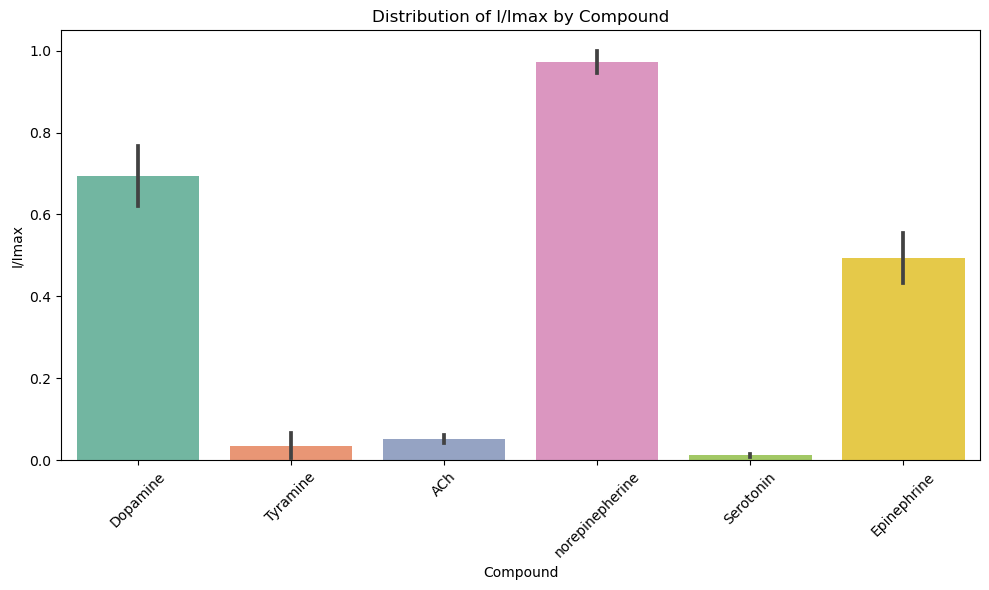

In [6]:
# Choose the filename you want to filter by
#chosen_filename = 'Agonist Parasitic Plate 8 H Contortus pIH 222_...'  # replace with your exact filename or partial string

# Filter the data
#filtered_data = normdata[normdata['Filename'] == chosen_filename]

# Now plot with the filtered data
plt.figure(figsize=(10, 6))
sns.barplot(data=normdata, x='Comp. 1', y='I/Imax', palette='Set2', errorbar='se')

plt.title(f'Distribution of I/Imax by Compound')
plt.xlabel('Compound')
plt.ylabel('I/Imax')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
grouped_data = normdata.groupby(['Construct', 'Comp. 1']) #view grouped data
mean_data = grouped_data['I/Imax'].describe()
mean_data

count      mean       std       min       25%  \
Construct Comp. 1                                                          
WT        ACh                7.0  0.051451  0.023696  0.010870  0.040470   
          Dopamine           7.0  0.694560  0.193831  0.451200  0.571541   
          Epinephrine        7.0  0.493141  0.163037  0.296875  0.362636   
          Serotonin          7.0  0.011700  0.008418  0.005339  0.006167   
          Tyramine           7.0  0.035311  0.082529 -0.010069 -0.002107   
          norepinepherine    7.0  0.972923  0.071639  0.810462  1.000000   

                                50%       75%       max  
Construct Comp. 1                                        
WT        ACh              0.055348  0.063964  0.085074  
          Dopamine         0.709888  0.778875  1.000000  
          Epinephrine      0.495160  0.591873  0.750933  
          Serotonin        0.006623  0.016235  0.025135  
          Tyramine         0.006623  0.017005  0.220826  
          norepinepherine  1.000000  1.000000  1.000000

In [8]:
export_data = normdata
export_mean = mean_data

output_folder = os.path.join(path, 'outputs')
os.makedirs(output_folder, exist_ok=True)

output_file = os.path.join(output_folder, 'peak_current_norm_mean.csv')
export_mean.to_csv(output_file, index=True)

output_file = os.path.join(output_folder, 'peak_current_norm.csv')
export_data.to_csv(output_file, index=True)